# Face Recognition

In [230]:
import pandas as pd
import base64
import numpy as np
from PIL import Image
import io
import cv2 as cv2
from io import BytesIO
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random as rand
import dlib
import pixiedust
colors = sns.color_palette()

Pixiedust database opened successfully


### Load celebrity name data

In [50]:
celebName = pd.read_csv('Top1M_MidList.Name.tsv', delimiter='\t', error_bad_lines=False)
language = celebName['Name'].str.split("@", n=1, expand=True)
celebName['Name'] = language[0]
celebName['Language'] = language[1]
celebName = celebName[celebName['Language'] == 'en']
celebName.drop(columns=['Language'], inplace=True)

### Load celebrity images

In [52]:
clebs = pd.read_csv('images.tsv', delimiter="\t", engine='python', error_bad_lines=False)

### Join on id

In [55]:
clebs = clebs.merge(celebName, how='left', left_on='Id', right_on='Id')
del celebName

### Data distribution

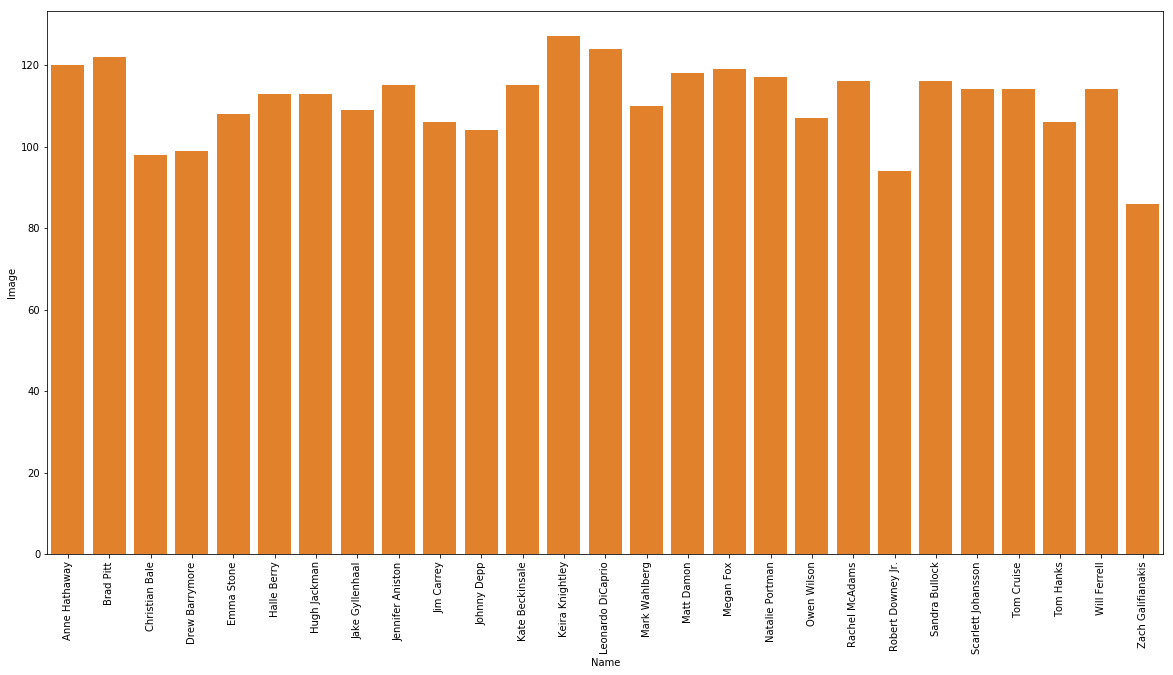

In [77]:
celebCount = clebs.groupby(['Name']).count().reset_index()
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.barplot(x='Name', y='Image', data=celebCount, color = colors[1])
plt.show()

In [240]:
def get_image(base64Image, display=True):
    img = Image.open(BytesIO(base64.b64decode(base64Image))).convert('RGB') 
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(img)
    return img
#   to open image in new window
#   img.show()

def get_opencv2_image(base64Image, display=False):
    return cv2.cvtColor(np.array(get_image(base64Image, display)), cv2.COLOR_RGB2BGR)

def convertToRGB(opencv2_image):
    return cv2.cvtColor(opencv2_image, cv2.COLOR_BGR2RGB)

# TODO

In [241]:
def rect_to_cordinate(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

In [242]:
def detect_faces(test_image, display=True, scaleFactor = 1.1):
    face_detector = dlib.get_frontal_face_detector()
    faces_rect = face_detector(img_raw,1)
    image_copy = test_image.copy()
    for rect in faces_rect:
        (x,y,w,h) = rect_to_cordinate(rect)
        cv2.rectangle(image_copy, (x,y), (x+w, y+h), (0,255,255), 2)
    
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(convertToRGB(image_copy))
    
    return faces_rect

In [243]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
 
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
 
    # return the list of (x, y)-coordinates
    return coords

In [244]:
def detect_landmarks(image, faces, display=True):
    test_copy = image.copy()
    face_pose_predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")
    for face in faces:
        pose_landmarks = face_pose_predictor(test_copy, face)
        for (x, y) in shape_to_np(pose_landmarks):
            cv2.circle(test_copy, (x, y), 1, (0,0,255), -1)
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(convertToRGB(test_copy))
    return pose_landmarks

### Detect Faces

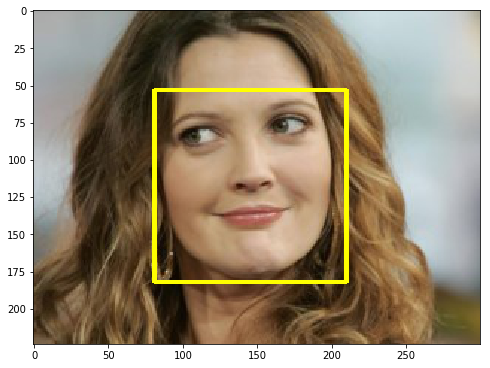

In [245]:
i = rand.randrange(0,len(clebs))
base64image = clebs.iloc[i]['Image']
img_raw = get_opencv2_image(base64image)
faces = detect_faces(img_raw)

## Dectect landmarks

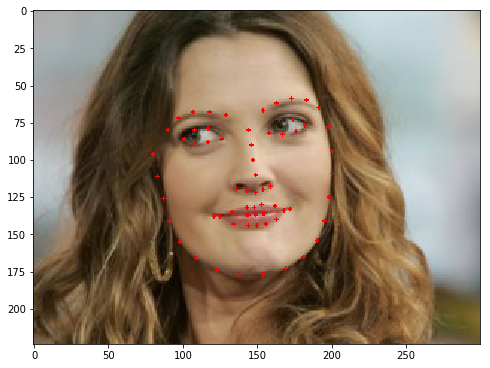

In [246]:
landmarks = detect_landmarks(img_raw, faces)